# Elastic Rod Model

In [1]:
from IPython.display import display, Markdown
import random
def latexify(x):
    out = '$' + x + '$'
    return out

def lprint(x):
    display(Markdown(latexify(latex(x))))
    
%run -i 'implicit.py'

In this notebook a discretisation of the elastic rod bifurcation problem will be investigated

https://pubs.rsc.org/en/content/chapterhtml/2015/bk9781849738132-00001?isbn=978-1-84973-813-2&sercode=bk

derives a system of equations that correspond to a period truss network model for an elastic rod.

In [2]:
def get_funcs(n, f = None):
    # returns a set of equations to solve
    if f is None:
        var('x')
        f = x # default spring energy function
        
    var_dict = {}
    for i in range(0,n+1):
        # create a grid
        # Pij is the displacement from the point (i,j) on the grid
        # then split into x,y position of where that point goes
        var_dict['p{}0x'.format(i)] = var('p{}0x'.format(i))
        var_dict['p{}0y'.format(i)] = var('p{}0y'.format(i))
        var_dict['p{}1x'.format(i)] = var('p{}1x'.format(i))
        var_dict['p{}1y'.format(i)] = var('p{}1y'.format(i))
        
    # enforce fixed points at left side of truss network
    var_dict['p00x'] = 0
    var_dict['p00y'] = 0
    var_dict['p01x'] = 0
    var_dict['p01y'] = 0 
    
    var_dict['l'] = var('l', latex_name=r'\lambda') # forced constriction
    
    var_dict['p{}0x'.format(n)] = var_dict['l'] - n
    var_dict['p{}1x'.format(n)] = var_dict['l'] - n
    var_dict['p{}0y'.format(n)] = 0 # these don't change
    var_dict['p{}1y'.format(n)] = 0 # could do in a later implementation though  
   
    
    # so after constraints at endpoints we have 4(n-1) uknowns
    
    funcs = []
    e_truss = 0
    for j in range(1,n+1):
        # iterate through each square in the truss
        # get the length of each of the five springs
        
        top_x = 1 + var_dict['p{}1x'.format(j)] - var_dict['p{}1x'.format(j-1)]
        top_y = var_dict['p{}1y'.format(j)] - var_dict['p{}1y'.format(j-1)]  
        top = f(sqrt(top_x^2 + top_y^2))
        
        right_x = var_dict['p{}1x'.format(j)] - var_dict['p{}0x'.format(j)] 
        right_y = 1 + var_dict['p{}1y'.format(j)] - var_dict['p{}0y'.format(j)] 
        right = f(sqrt(right_x^2 + right_y^2))
 
        bottom_x = 1 + var_dict['p{}0x'.format(j)] - var_dict['p{}0x'.format(j-1)]
        bottom_y = var_dict['p{}0y'.format(j)] - var_dict['p{}0y'.format(j-1)]  
        bottom = f(sqrt(bottom_x^2 + bottom_y^2))
        
        
        # \ spring
        diag1_x = 1 + var_dict['p{}0x'.format(j)] - var_dict['p{}1x'.format(j-1)]
        diag1_y = 1 + var_dict['p{}1y'.format(j-1)] - var_dict['p{}0y'.format(j)]
        diag1 = f(sqrt(diag1_x^2 + diag1_y^2)/sqrt(2)) # scale by root 2
        
        
        # / spring
        diag2_x = 1 + var_dict['p{}1x'.format(j)] - var_dict['p{}0x'.format(j-1)]
        diag2_y = 1 + var_dict['p{}1y'.format(j)] - var_dict['p{}0y'.format(j-1)]
        diag2 = f(sqrt(diag1_x^2 + diag1_y^2)/sqrt(2)) # so that zero is indeed a solution 
        
        e_truss = e_truss + top + right + bottom + diag1 + diag2
        
        
    # solutions will be local minima of the energy equation
    for j in range(1,n):
        # only care about 1,...,n
        # 0 and n are fixed points
        funcs.append(e_truss.diff(var_dict['p{}0x'.format(j)]))
        funcs.append(e_truss.diff(var_dict['p{}0y'.format(j)]))
        funcs.append(e_truss.diff(var_dict['p{}1x'.format(j)]))
        funcs.append(e_truss.diff(var_dict['p{}1y'.format(j)]))
        
        
    var_dict['p{}0x'.format(n)] = 0
    var_dict['p{}1x'.format(n)] = 0 
    # these we just latent variables, they never really existed
        
    return funcs, var_dict
    

In [3]:
funcs, var_dict = get_funcs(2,f = (x-1)^2)

implicit.py:1: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.
  from math import factorial


In [4]:
var_dict

{'p00x': 0,
 'p00y': 0,
 'p01x': 0,
 'p01y': 0,
 'p10x': p10x,
 'p10y': p10y,
 'p11x': p11x,
 'p11y': p11y,
 'p20x': 0,
 'p20y': 0,
 'p21x': 0,
 'p21y': 0,
 'l': l}

In [5]:
lprint(funcs)

$ \left[\frac{\sqrt{2} {\left(\sqrt{2} \sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + {\left(\mathit{p10y} - 1\right)}^{2}} - 2\right)} {\left(\mathit{p10x} + 1\right)}}{\sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + {\left(\mathit{p10y} - 1\right)}^{2}}} - \frac{2 \, {\left({\lambda} - \mathit{p10x} - 1\right)} {\left(\sqrt{{\left({\lambda} - \mathit{p10x} - 1\right)}^{2} + \mathit{p10y}^{2}} - 1\right)}}{\sqrt{{\left({\lambda} - \mathit{p10x} - 1\right)}^{2} + \mathit{p10y}^{2}}} + \frac{2 \, {\left(\mathit{p10x} - \mathit{p11x}\right)} {\left(\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}}} + \frac{2 \, {\left(\mathit{p10x} + 1\right)} {\left(\sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + \mathit{p10y}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + \mathit{p10y}^{2}}}, \frac{\sqrt{2} {\left(\sqrt{2} \sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + {\left(\mathit{p10y} - 1\right)}^{2}} - 2\right)} {\left(\mathit{p10y} - 1\right)}}{\sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + {\left(\mathit{p10y} - 1\right)}^{2}}} + \frac{2 \, \mathit{p10y} {\left(\sqrt{{\left({\lambda} - \mathit{p10x} - 1\right)}^{2} + \mathit{p10y}^{2}} - 1\right)}}{\sqrt{{\left({\lambda} - \mathit{p10x} - 1\right)}^{2} + \mathit{p10y}^{2}}} + \frac{2 \, {\left(\mathit{p10y} - \mathit{p11y} - 1\right)} {\left(\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}}} + \frac{2 \, \mathit{p10y} {\left(\sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + \mathit{p10y}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} + 1\right)}^{2} + \mathit{p10y}^{2}}}, -\frac{\sqrt{2} {\left(\sqrt{2} \sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + {\left(\mathit{p11y} + 1\right)}^{2}} - 2\right)} {\left({\lambda} - \mathit{p11x} - 1\right)}}{\sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + {\left(\mathit{p11y} + 1\right)}^{2}}} - \frac{2 \, {\left({\lambda} - \mathit{p11x} - 1\right)} {\left(\sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + \mathit{p11y}^{2}} - 1\right)}}{\sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + \mathit{p11y}^{2}}} - \frac{2 \, {\left(\mathit{p10x} - \mathit{p11x}\right)} {\left(\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}}} + \frac{2 \, {\left(\mathit{p11x} + 1\right)} {\left(\sqrt{{\left(\mathit{p11x} + 1\right)}^{2} + \mathit{p11y}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p11x} + 1\right)}^{2} + \mathit{p11y}^{2}}}, \frac{\sqrt{2} {\left(\sqrt{2} \sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + {\left(\mathit{p11y} + 1\right)}^{2}} - 2\right)} {\left(\mathit{p11y} + 1\right)}}{\sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + {\left(\mathit{p11y} + 1\right)}^{2}}} + \frac{2 \, \mathit{p11y} {\left(\sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + \mathit{p11y}^{2}} - 1\right)}}{\sqrt{{\left({\lambda} - \mathit{p11x} - 1\right)}^{2} + \mathit{p11y}^{2}}} - \frac{2 \, {\left(\mathit{p10y} - \mathit{p11y} - 1\right)} {\left(\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}}} + \frac{2 \, \mathit{p11y} {\left(\sqrt{{\left(\mathit{p11x} + 1\right)}^{2} + \mathit{p11y}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p11x} + 1\right)}^{2} + \mathit{p11y}^{2}}}\right] $

In [6]:
lprint(funcs[1](2,0,0,0,0)) # lambda = 2 corresponds to no compression

$ 0 $

In [7]:
lprint(funcs[0](1.5,0,0,0,0)) # however see that we no longer have trivial solutions

$ 1.00000000000000 $

In [11]:
def get_trivial_sols(n):
    var_dict = {}
    sol_dict = {}
    var_dict['l'] = var('l', latex_name=r'\lambda')
    for i in range(1,n):
        var_dict['p{}0x'.format(i)] = var('p{}0x'.format(i))
        var_dict['p{}0y'.format(i)] = var('p{}0y'.format(i))
        var_dict['p{}1x'.format(i)] = var('p{}1x'.format(i))
        var_dict['p{}1y'.format(i)] = var('p{}1y'.format(i))
        
        sol_dict['p{}0x'.format(i)] = var_dict['l']*i/n - i 
        sol_dict['p{}0y'.format(i)] = -var('p{}1y'.format(i))
        sol_dict['p{}1x'.format(i)] = var_dict['l']*i/n - i 
        sol_dict['p{}1y'.format(i)] = var('p{}1y'.format(i))
        
    return sol_dict     

In [12]:
sols = get_trivial_sols(2)
sols

{'p10x': 1/2*l - 1, 'p10y': -p11y, 'p11x': 1/2*l - 1, 'p11y': p11y}

In [19]:
lprint((funcs[3](**sols)))

$ \frac{\sqrt{2} {\left(\sqrt{2} \sqrt{{\lambda}^{2} + 4 \, {\left(\mathit{p11y} + 1\right)}^{2}} - 4\right)} {\left(\mathit{p11y} + 1\right)}}{\sqrt{{\lambda}^{2} + 4 \, {\left(\mathit{p11y} + 1\right)}^{2}}} + \frac{4 \, \mathit{p11y} {\left(\sqrt{{\lambda}^{2} + 4 \, \mathit{p11y}^{2}} - 2\right)}}{\sqrt{{\lambda}^{2} + 4 \, \mathit{p11y}^{2}}} + \frac{2 \, {\left(2 \, \mathit{p11y} + 1\right)} {\left(\sqrt{{\left(2 \, \mathit{p11y} + 1\right)}^{2}} - 1\right)}}{\sqrt{{\left(2 \, \mathit{p11y} + 1\right)}^{2}}} $

we see that the we get a solution independant of the input for lambda

In [14]:
def get_trivial_free(n):
    var_dict = {}
    sol_dict = {}
    var_dict['l'] = var('l', latex_name=r'\lambda')
    for i in range(1,n):
        var_dict['p{}0x'.format(i)] = var('p{}0x'.format(i))
        var_dict['p{}0y'.format(i)] = var('p{}0y'.format(i))
        var_dict['p{}1x'.format(i)] = var('p{}1x'.format(i))
        var_dict['p{}1y'.format(i)] = var('p{}1y'.format(i))
        
        sol_dict['p{}0x'.format(i)] = var_dict['l']*i/n - i 
        sol_dict['p{}0y'.format(i)] = -var('p{}1y'.format(i))
        sol_dict['p{}1x'.format(i)] = var_dict['l']*i/n - i 
        sol_dict['p{}1y'.format(i)] = var('p{}1y'.format(i))
        
    return sol_dict 

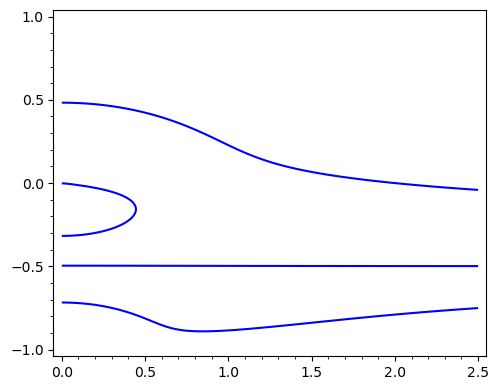

In [15]:
sols = get_trivial_free(2)
sols
implicit_plot(funcs[3](**sols), (0,2.5), (-1,1))

We also see that a bifurcation occurs in these solutions (assuming symmmetry), which corresponds to the truss "squishing"

$ p11y = \frac{1}{2} \sqrt{1 - \lambda ^2} $ can be shown to be the solution

In [13]:
def get_trivial_bif(n):
    var_dict = {}
    sol_dict = {}
    var_dict['l'] = var('l', latex_name=r'\lambda')
    for i in range(1,n):
        var_dict['p{}0x'.format(i)] = var('p{}0x'.format(i))
        var_dict['p{}0y'.format(i)] = var('p{}0y'.format(i))
        var_dict['p{}1x'.format(i)] = var('p{}1x'.format(i))
        var_dict['p{}1y'.format(i)] = var('p{}1y'.format(i))
        
        sol_dict['p{}0x'.format(i)] = var_dict['l']*i/n - i 
        sol_dict['p{}0y'.format(i)] = - (1/2) * sqrt(1 - var_dict['l']^2)
        sol_dict['p{}1x'.format(i)] = var_dict['l']*i/n - i 
        sol_dict['p{}1y'.format(i)] = (1/2) * sqrt(1 - var_dict['l']^2)
        
    return sol_dict   

In [14]:
sols = get_trivial_bif(2)
sols

{'p10x': 1/2*l - 1,
 'p10y': -1/2*sqrt(-l^2 + 1),
 'p11x': 1/2*l - 1,
 'p11y': 1/2*sqrt(-l^2 + 1)}

In [15]:
lprint(simplify(funcs[3](**sols)))

$ 0 $

In [16]:
def get_perturbed_funcs(n):
    # returns a set of equations to solve
    
    funcs, var_dict = get_funcs(n,(x-1)^2)
    
    sols = get_trivial_sols(2)
    
    for var in sols.keys():
        sols[var] = var_dict[var] + sols[var] # update with shift of the trivial solution
    
    for i in range(0, len(funcs)):
        funcs[i] = funcs[i](**sols)
        
    return funcs, var_dict

In [17]:
funcs, var_dict = get_perturbed_funcs(2)

implicit.py:4: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.
  import numpy as np


In [18]:
lprint(funcs[0])

$ \frac{{\left({\lambda} + 2 \, \mathit{p10x}\right)} {\left(\sqrt{{\left({\lambda} + 2 \, \mathit{p10x}\right)}^{2} + 4 \, \mathit{p10y}^{2}} - 2\right)}}{\sqrt{{\left({\lambda} + 2 \, \mathit{p10x}\right)}^{2} + 4 \, \mathit{p10y}^{2}}} - \frac{{\left({\lambda} - 2 \, \mathit{p10x}\right)} {\left(\sqrt{{\left({\lambda} - 2 \, \mathit{p10x}\right)}^{2} + 4 \, \mathit{p10y}^{2}} - 2\right)}}{\sqrt{{\left({\lambda} - 2 \, \mathit{p10x}\right)}^{2} + 4 \, \mathit{p10y}^{2}}} + \frac{2 \, {\left(\mathit{p10x} - \mathit{p11x}\right)} {\left(\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} - \mathit{p11x}\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y} - 1\right)}^{2}}} $

In [19]:
lprint(funcs[3](1.78,0,0,0,0))

$ 0 $

In [22]:
lprint(funcs[2](1.9,0,0,0,0))

$ 0.000000000000000 $

Now we have trivial solutions

In [23]:
old_var = var_dict
var_dict = {key : var_dict[key] for key in var_dict.keys() if var_dict[key] != 0}
var_dict = {key : var_dict[key] for key in var_dict.keys() if key != 'l'}

J = jacobian(funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(J)

$ \left(\begin{array}{rrrr}
4 & 0 & 0 & 0 \\
0 & \frac{2 \, {\left(3 \, \sqrt{{\lambda}^{2}} - 4\right)}}{\sqrt{{\lambda}^{2}}} & 0 & -2 \\
0 & 0 & 4 & 0 \\
0 & -2 & 0 & \frac{2 \, {\left(3 \, \sqrt{{\lambda}^{2}} - 4\right)}}{\sqrt{{\lambda}^{2}}}
\end{array}\right) $

In [24]:
lprint(det(matrix(J))) # potential bifurcation point

$ -\frac{1536}{\sqrt{{\lambda}^{2}}} + \frac{1024}{{\lambda}^{2}} + 512 $

In [25]:
lprint(det(matrix(J))(l =1))

$ 0 $

In [26]:
lprint(det(matrix(J))(l = 2))

$ 0 $

Suggest bifurcations at $\lambda = 2$ and $\lambda = 1$

In [50]:
#bif_funcs = [func(l = 2/((32*sqrt(2)) + 36)) for func in funcs] #
#bif_funcs = [func(l = (sqrt(2)*(9/4))/((225*sqrt(2))/2 + 108)) for func in funcs] #
bif_funcs = [func(l = 1) for func in funcs]
#var_dict['l'] = old_var['l']
J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()})

lprint(J)

$ \left(\begin{array}{rrrr}
4 & 0 & 0 & 0 \\
0 & -2 & 0 & -2 \\
0 & 0 & 4 & 0 \\
0 & -2 & 0 & -2
\end{array}\right) $

In [51]:
lprint(det(matrix(J.rows()[0:6])))

$ 0 $

### Orthogonalising the kernel

In [52]:
K = J.right_kernel().basis()
lprint(K)

$ \left[\left(0,\,1,\,0,\,-1\right)\right] $

In [53]:
Kperp = matrix(K).right_kernel().basis()
lprint(Kperp)

$ \left[\left(1,\,0,\,0,\,0\right), \left(0,\,1,\,0,\,1\right), \left(0,\,0,\,1,\,0\right)\right] $

In [54]:
A = matrix(K+Kperp).inverse().apply_map(lambda x: x.full_simplify())
lprint(A)

$ \left(\begin{array}{rrrr}
0 & 1 & 0 & 0 \\
\frac{1}{2} & 0 & \frac{1}{2} & 0 \\
0 & 0 & 0 & 1 \\
-\frac{1}{2} & 0 & \frac{1}{2} & 0
\end{array}\right) $

In [55]:
key_list = [str(var) for var in var_dict.values()]
value_list = list(A*vector(var_dict.values()))
mutate_dict = dict(zip(key_list, value_list))

In [56]:
mutate_dict

{'p10x': p10y,
 'p10y': 1/2*p10x + 1/2*p11x,
 'p11x': p11y,
 'p11y': -1/2*p10x + 1/2*p11x}

In [57]:
Afuncs = [func(**mutate_dict) for func in bif_funcs]

In [58]:
#lprint(Afuncs) 

In [59]:
Ja = jacobian(Afuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(Ja)

$ \left(\begin{array}{rrrr}
0 & 4 & 0 & 0 \\
0 & 0 & -2 & 0 \\
0 & 0 & 0 & 4 \\
0 & 0 & -2 & 0
\end{array}\right) $

In [60]:
Ka = Ja(l=0).right_kernel().basis()
lprint(Ka)

$ \left[\left(1,\,0,\,0,\,0\right)\right] $

### Orthogonalising the image

In [61]:
I = Ja.image().basis()
I = [Ja*vec for vec in I]
print(len(I))

3


In [62]:
Iperp = matrix(I).right_kernel().basis()
lprint(Iperp)

$ \left[\left(0,\,1,\,0,\,-1\right)\right] $

In [63]:
B = matrix(I + Iperp).inverse().apply_map(lambda x: x.full_simplify())
lprint(B)

$ \left(\begin{array}{rrrr}
\frac{1}{4} & 0 & 0 & 0 \\
0 & -\frac{1}{4} & 0 & \frac{1}{2} \\
0 & 0 & \frac{1}{4} & 0 \\
0 & -\frac{1}{4} & 0 & -\frac{1}{2}
\end{array}\right) $

In [64]:
tfuncs = vector(Afuncs)*B

In [65]:
#lprint(tfuncs)

In [66]:
Jt = jacobian(tfuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())

In [67]:
var_dict.values()

dict_values([p10x, p10y, p11x, p11y])

In [68]:
lprint(Jt)

$ \left(\begin{array}{rrrr}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0
\end{array}\right) $

In [69]:
It = Jt.image().basis()
It = [Jt*vec for vec in It]
lprint(It)

$ \left[\left(1,\,0,\,0,\,0\right), \left(0,\,1,\,0,\,0\right), \left(0,\,0,\,1,\,0\right)\right] $

## Adding lambda back in

In [71]:
tfuncs = vector([func(**mutate_dict)(l = l + 1) for func in funcs])*B # now lambda is not fixed at the bifurcation point
# ***IF SOMETHING IS BROKEN CHECK RIGHT LAMBDA HERE***
# but we do shift so that l=0 is the new bifurcation
var_dict['l'] = l

In [72]:
var_dict_old = var_dict
var_dict_old

{'p10x': p10x, 'p10y': p10y, 'p11x': p11x, 'p11y': p11y, 'l': l}

In [73]:
var_dict.values()

dict_values([p10x, p10y, p11x, p11y, l])

In [74]:
lprint(tfuncs[3])

$ \frac{{\left(\mathit{p10x} + \mathit{p11x}\right)} {\left(\sqrt{{\left({\lambda} + 2 \, \mathit{p10y} + 1\right)}^{2} + {\left(\mathit{p10x} + \mathit{p11x}\right)}^{2}} - 2\right)}}{2 \, \sqrt{{\left({\lambda} + 2 \, \mathit{p10y} + 1\right)}^{2} + {\left(\mathit{p10x} + \mathit{p11x}\right)}^{2}}} + \frac{{\left(\mathit{p10x} + \mathit{p11x}\right)} {\left(\sqrt{{\left({\lambda} - 2 \, \mathit{p10y} + 1\right)}^{2} + {\left(\mathit{p10x} + \mathit{p11x}\right)}^{2}} - 2\right)}}{2 \, \sqrt{{\left({\lambda} - 2 \, \mathit{p10y} + 1\right)}^{2} + {\left(\mathit{p10x} + \mathit{p11x}\right)}^{2}}} + \frac{{\left(\mathit{p10x} - \mathit{p11x}\right)} {\left(\sqrt{{\left({\lambda} + 2 \, \mathit{p11y} + 1\right)}^{2} + {\left(\mathit{p10x} - \mathit{p11x}\right)}^{2}} - 2\right)}}{2 \, \sqrt{{\left({\lambda} + 2 \, \mathit{p11y} + 1\right)}^{2} + {\left(\mathit{p10x} - \mathit{p11x}\right)}^{2}}} + \frac{{\left(\mathit{p10x} - \mathit{p11x}\right)} {\left(\sqrt{{\left({\lambda} - 2 \, \mathit{p11y} + 1\right)}^{2} + {\left(\mathit{p10x} - \mathit{p11x}\right)}^{2}} - 2\right)}}{2 \, \sqrt{{\left({\lambda} - 2 \, \mathit{p11y} + 1\right)}^{2} + {\left(\mathit{p10x} - \mathit{p11x}\right)}^{2}}} + \frac{2 \, {\left(\mathit{p10x} - 1\right)} {\left(\sqrt{{\left(\mathit{p10x} - 1\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y}\right)}^{2}} - 1\right)}}{\sqrt{{\left(\mathit{p10x} - 1\right)}^{2} + {\left(\mathit{p10y} - \mathit{p11y}\right)}^{2}}} $

## Running the implicit function theorem

In [75]:
position = {key : 0 for key in var_dict_old.keys()}
position

{'p10x': 0, 'p10y': 0, 'p11x': 0, 'p11y': 0, 'l': 0}

In [76]:
#code_funcs = [tfuncs[index].function(*list(var_dict_old.values())) for index in [0,1,2,3,4,5,6]] # careful with computer science indexing from zero
code_funcs = [tfuncs[index] for index in [0,1,2]] # the last function has degenerate first derivative always
position = {key : 0 for key in var_dict_old.keys()}
# var_dict already loaded
var_dict = {'y1' : p10y, 'y2' : p11x, 'y3' : p11y, 'x1' : l, 'x2' : p10x}
x_var_keys = ['l', 'p10x'] # the variables in the kernel
x_dim = 2
y_dim = 3 # invertible part

In [77]:
var_dict.keys()

dict_keys(['y1', 'y2', 'y3', 'x1', 'x2'])

In [78]:
t_dict = TensorDict(code_funcs, position, var_dict, x_dim, y_dim)

computing Taylor approximaton to 3 order for speedup


In [79]:
out = get_hkx_polynomial(code_funcs, 3, x_dim, y_dim, var_dict, x_var_keys, t_dict, position)

100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


[1 0 0]
[0 1 0]
[0 0 1]


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


[1 0 0]
[0 1 0]
[0 0 1]


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


[1 0 0]
[0 1 0]
[0 0 1]


In [80]:
lprint(out)

$ \left[0, 0, 0\right] $

In [65]:
t_dict

{'fX': <__main__.SymbolicXYVectorTensor object at 0x6ffe3bc81bd0>, 'hX': <__main__.SymbolicXYVectorTensor object at 0x6ffe3d751690>, 'fXX': <__main__.SymbolicXYVectorTensor object at 0x6ffe3bc54ed0>, 'fXY': <__main__.SymbolicXYVectorTensor object at 0x6ffe3bc5b0d0>, 'fYY': <__main__.SymbolicXYVectorTensor object at 0x6ffe3d75f190>, 'hXX': <__main__.SymbolicXYVectorTensor object at 0x6ffe3f8d6f90>, 'fXXX': <__main__.SymbolicXYVectorTensor object at 0x6ffe3bcde150>, 'fXXY': <__main__.SymbolicXYVectorTensor object at 0x6ffe3bc6a750>, 'fXYY': <__main__.SymbolicXYVectorTensor object at 0x6ffe41a095d0>, 'fYYY': <__main__.SymbolicXYVectorTensor object at 0x6ffe3bcdec90>, 'hXXX': <__main__.SymbolicXYVectorTensor object at 0x6ffe40514050>}

In [98]:
t_dict['fXXX'].tensors[2].data

data
1  2  3      
x1 x1 x1    0
      x2    0
   x2 x1    0
      x2    0
x2 x1 x1    0
      x2    0
   x2 x1    0
      x2    0

## Testing the implicit function theorem

In [ ]:
subbed = [func(p10y = out[0], p11x = out[1], p11y = out[2]) for func in tfuncs]

In [ ]:
[float(func(l = 0.1, p10x = 0.1)) for func in subbed]

the last function remains to be solved

### Looking for more solutions

Now substitute this into the equation that had degenerate image

In [ ]:
loc = [(value,0) for value in var_dict_old.values() ] + [3]
print(loc)

In [ ]:
#lprint(taylor(tfuncs[5], *loc))

In [ ]:
tf_taylor = tfuncs[3].taylor(*[(key,value) for key,value in position.items()],3)
#lprint(tf_taylor.polynomial(SR))

In [ ]:
#var_dict_old

In [ ]:
tf_sub = tf_taylor(p10y = out[0], p11x = out[1], p11y = out[2])

In [ ]:
local = symbolic_expression(sum([a[0]*a[1] for a in tf_sub.polynomial(SR) if a[1].degree() <= 2]))
#local = tf_sub.polynomial(SR).truncate(4)
lprint(local)

We see that this will have solutions, therefore the point $\lambda$ is indeed a bifurcation point, and if we fix the $p10x$ variable at zero then $\lambda$ will span the local solutions.

In [ ]:
lprint(solve(local, p10x))

In [ ]:
implicit_plot(local, (-1,5), (-5,5))

Now we can inspect the value of the kernel to see what the new solutions look like

In [ ]:
sols = out + [0.1] # try xi = 0.1 to start with

In [ ]:
fsols = list(A*vector(sols)(l = 2))
fsols

### Generating more solutions

We have solved $f \circ A$ where $A$ orthogonalised the kernel, thus by applying $A$ we can get a traversel of the new solutions.

In [ ]:
eps = 0.01

In [ ]:
strand = solve(local, p10x)[0].rhs()

out2 = [exp(p10x = strand) for exp in out]
sols = [strand] + out2
#[sol(l = 0.01) for sol in sols]

#sols = [0.1] + [exp(p10x = 0.1, l = 0.1) for exp in out]
#[sol(l = 0.001) for sol in sols]
#lprint(sols)

In [ ]:
strand

In [ ]:
strand(l = eps) # the big scaling means we need to choose a very small lambda

In [ ]:
#subbed = [func(p10y = out[0], p11x = out[1], p11y = out[2], p20x = out[3], p21x = out[4]) for func in tfuncs]

subbed = [func(p10x = sols[0], p10y = sols[1], p11x = sols[2], p11y = sols[3], p20x = sols[4], p21x = sols[5]) for func in tfuncs]
[float(func(l = eps)) for func in subbed]

In [ ]:
#lprint(A*vector(sols))

In [ ]:
fsols = list(A*vector(sols)(l = eps))
fsols

In [ ]:
#fsols = [random.random()/1000 for i in range(0,6)] # can check these are giving solutions

In [ ]:
coords = { list(var_dict_old.keys())[i] : fsols[i] for i in [0,1,2,3,4,5] }
coords['l'] = eps
coords

In [ ]:
funcs[0].function(*list(var_dict_old.values()))(**coords)

In [ ]:
sym_funcs = [func.function(*list(var_dict_old.values())) for func in funcs] # convert to symbolic functions

In [ ]:
[float(func(**coords)) for func in sym_funcs]

In [ ]:
lprint(A)

In [ ]:
lprint(sym_funcs[0])

In [ ]:
mutate_dict

In [ ]:
lprint(sym_funcs[4])

### 